In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.tight_layout()
import pprint as pp

<Figure size 432x288 with 0 Axes>

In [2]:
import sklearn
import sklearn.ensemble
import sklearn.metrics
from sklearn import datasets, ensemble, model_selection

In [3]:
#!pip install eli5
#!pip install shap
#!pip install dalex
#!pip install lime
import eli5
import shap
import lime

/home/datacarpenter/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/datacarpenter/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
C_housing=sklearn.datasets.fetch_california_housing()
feature_names= C_housing.feature_names
data= pd.DataFrame(C_housing.data, columns=feature_names)

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    data, C_housing.target)

regressor = ensemble.RandomForestRegressor(max_depth=5, n_estimators=150)
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=150)

In [75]:
#built in  model specific feature_importance
feat_imp=list(zip(regressor.feature_importances_, C_housing.feature_names))
feat_imp.sort(reverse=True)
feat_imp

[(0.7505003842418875, 'MedInc'),
 (0.13510888766372608, 'AveOccup'),
 (0.044584204336255075, 'HouseAge'),
 (0.031100175057545698, 'Latitude'),
 (0.02131205217517504, 'Longitude'),
 (0.012791091810143288, 'AveRooms'),
 (0.003425187282492473, 'Population'),
 (0.0011780174327748992, 'AveBedrms')]

In [9]:
instance= X_test.iloc[25]
instance

MedInc         12.591500
HouseAge        8.000000
AveRooms       10.511628
AveBedrms       1.186047
Population    140.000000
AveOccup        3.255814
Latitude       37.740000
Longitude    -121.920000
Name: 1564, dtype: float64

## Lime explains ONE prediction

In [76]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(X_train.values,
                                feature_names=C_housing.feature_names,
                                mode='regression')

[('MedInc > 4.76', 1.8471958923795728),
 ('2.82 < AveOccup <= 3.28', -0.2336834729741492),
 ('Latitude > 37.71', -0.2047809324575653),
 ('HouseAge <= 18.00', -0.20413089884033378),
 ('Longitude <= -121.80', 0.07642418296984194),
 ('AveBedrms > 1.10', 0.032074073155773465),
 ('Population <= 786.00', 0.011488109204597408),
 ('AveRooms > 6.06', -0.0013740020042784346)]


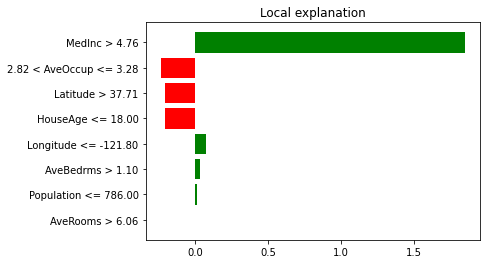

In [11]:

exp = explainer.explain_instance(instance, regressor.predict,
        num_features=100)

pp.pprint(exp.as_list())
exp.as_pyplot_figure()
plt.show()

In [12]:
exp = explainer.explain_instance(instance, regressor.predict,
        num_features=100)
exp.save_to_file('explanation.html')

In [13]:
exp.show_in_notebook()

In [14]:
#actual prediction
#feature effects for the instance.
#actual feature values for the instance

## Submodular Pick
Have a look at the decision boundary:  instances that are  a good representations of  the model surface

Submodular Pick for Explaining Models
Global understanding of the model by explaining a set of individual instances.
Define B to the number of explanations to be generated.
Pick Step - the task of selecting B instances for the user to inspect.
Aim to obtain non-redundant explanations that represent how the model behaves globally.
Given a matrix of n explanations, using d features (also called explanation matrix), rank the features such that the feature which explains more instances gets a higher score.
When selecting instances, avoid instances with similar explanation and try to increase coverage.

In [15]:
from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(
    explainer, X_train.values, regressor.predict, sample_size=20, num_features=14, num_exps_desired=5)

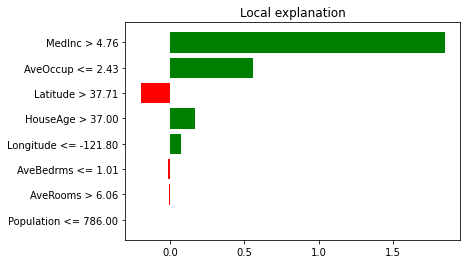

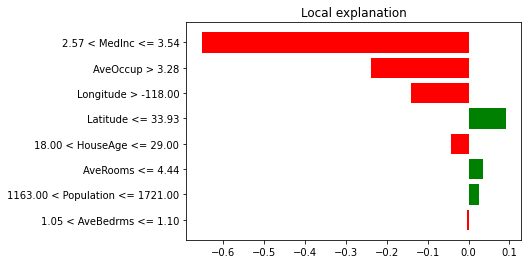

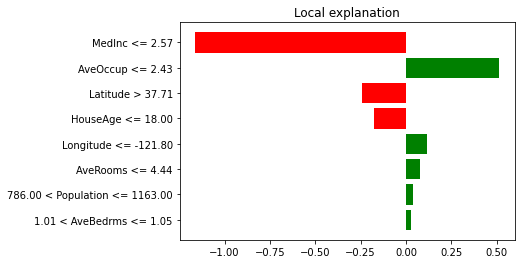

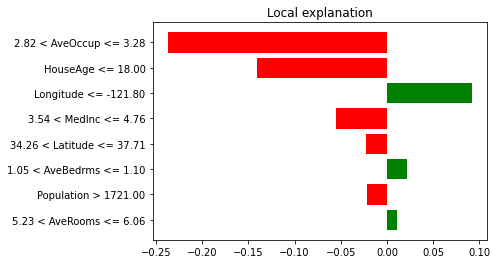

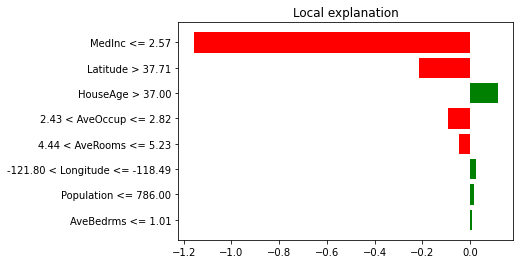

In [16]:
[exp.as_pyplot_figure() for exp in sp_obj.sp_explanations];

In [ ]:
## ELI5: permutation importance

In [22]:
# permutation ipmortance globally on train/ test

from eli5.sklearn import PermutationImportance

perm = PermutationImportance(regressor, n_iter=100).fit(X_test, y_test)
eli5.show_weights(perm,feature_names=feature_names)


In [23]:
#show weigths tries to assess the models  own feature importance 
eli5.show_weights(regressor, feature_names=feature_names)

In [24]:
#eli5 for a single  prediction

eli5.show_prediction(regressor, instance, feature_names=feature_names)

# SHAP
### Global feature importance 

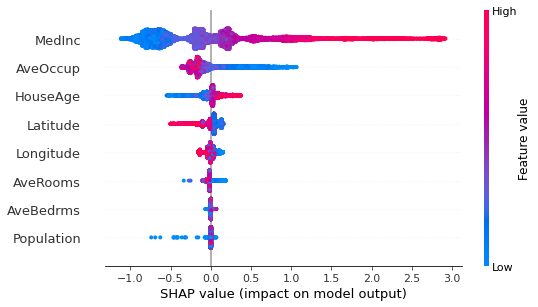

In [25]:
#dots are 
shap_values = shap.TreeExplainer(regressor).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='dot', feature_names=C_housing.feature_names)

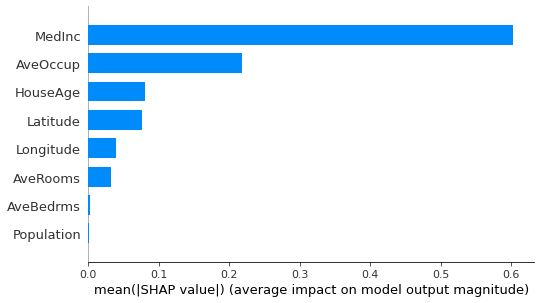

In [26]:
shap_values = shap.TreeExplainer(regressor).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=C_housing.feature_names)

In [52]:
shap.initjs()
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(instance)
shap.force_plot(explainer.expected_value, shap_values, instance)

In [23]:
#x_df=pd.DataFrame(X_test, columns=boston.feature_names)

In [27]:
##DALEX
import dalex as dx
exp_default = dx.Explainer(regressor, X_test, y_test, label='default_model' )

Preparation of a new explainer is initiated

  -> data              : 5160 rows 8 cols
  -> target variable   : 5160 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : default_model
  -> predict function  : <function yhat_default at 0x7fd96c1aa4c0> will be used (default)
  -> predict function  : accepts pandas.DataFrame and numpy.ndarray
  -> predicted values  : min = 0.89, mean = 2.07, max = 4.87
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -3.02, mean = -0.00256, max = 3.86
  -> model_info        : package sklearn

A new explainer has been created!


In [28]:
#http://dalex.drwhy.ai/python-dalex-fifa.html

In [30]:
model_performance= exp_default.model_performance(model_type="regression")
model_performance.result

mse      rmse        r2       mae       mad
default_model  0.444932  0.667032  0.668041  0.489381  0.370172

In [31]:
model_performance.plot()
#more useful for model comparison

In [ ]:
#Variable based dalex stuff

In [40]:
vi_default = exp_default.model_parts(B=15,variable_names=feature_names)
vi_default.plot(max_vars=15, )
#drop out loss: change in loss function.
#0.66 is the model error with all variables 

In [53]:
pdp_default = exp_default.model_profile( N=800, variables= ['MedInc', 'HouseAge'])
pdp_default.plot()

Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


In [54]:
# debuf, pdp vs aggregate 

In [56]:
##DALEX instancE LEVEL

i_break_down = exp_default.predict_parts(instance, type='break_down_interactions')
i_break_down.result.label = 'name'

In [58]:
i_break_down.plot()
#delta vs average response

In [63]:
shap = exp_default.predict_parts(instance, type='shap', B=10)
shap.plot()

In [73]:
#one record for SOME variable
ceteris_paribus = exp_default.predict_profile(instance, variables=['MedInc', 'HouseAge'])

Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00, 46.01it/s]


In [74]:
ceteris_paribus.plot()